## NREL

### Automated

In [1]:
import gc
import tempfile
import time
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from pathlib import Path

import boto3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from botocore import UNSIGNED
from botocore.client import Config
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from ml.predict import predict_ubem
from ml.surrogate import Surrogate
from tqdm.notebook import tqdm
from weather.weather import extract

# everything will go into and out of the root folder
root_folder = Path("data/resstock")
resstock_year = 2022
resstock_release = "tmy3_release_1.1"
amy_year = None
skip_gis_download_if_present = True
assert root_folder.exists(), f"{root_folder.as_posix()} does not exist"

# nrel bucket config
s3_nrel = boto3.client("s3", config=Config(signature_version=UNSIGNED))
nrel_bucket = "oedi-data-lake"
nrel_release_key = (
    Path("nrel-pds-building-stock")
    / "end-use-load-profiles-for-us-building-stock"
    / f"{resstock_year}"
    / f"resstock_{resstock_release}"
)
nrel_geo_folder = nrel_release_key / "geographic_information"
if amy_year:
    assert (
        "amy" in resstock_release.lower()
    ), "amy_year is set but amy resstock selected in amy release"
assert any(["amy" in resstock_release.lower(), "tmy" in resstock_release.lower()])
if "tmy" in resstock_release.lower():
    assert not amy_year, "amy_year is set but tmy resstock selected in amy release"

# in mem caches
surrogate_cache = {}
parquet_cache = {}
preds_cache = {}


# TODO: solar position computation; isolate and extract in climate
def calculate_dew_point(T, RH):
    # Constants for the Magnus-Tetens formula
    a = 17.62
    b = 243.12

    # Saturation vapor pressure (es)
    es = 6.112 * np.exp((a * T) / (b + T))

    # Actual vapor pressure (e)
    e = (RH / 100.0) * es

    # Dew point temperature (Td)
    Td = (b * np.log(e / 6.112)) / (a - np.log(e / 6.112))

    return Td


def download_and_open_epw_csv(
    s3_client, bucket: str, local_output_path: Path, key: str
):
    output_path = local_output_path / Path(key).name
    if output_path.exists():
        return pd.read_csv(output_path)
    s3_client.download_file(
        Bucket=bucket,
        Key=key,
        Filename=output_path.as_posix(),
    )
    return pd.read_csv(output_path)


channel_map = {
    "dry_bulb_temperature": "Dry Bulb Temperature [°C]",
    "dew_point_temperature": lambda data: calculate_dew_point(
        data["Dry Bulb Temperature [°C]"], data["Relative Humidity [%]"]
    ),
    "relative_humidity": "Relative Humidity [%]",
    "wind_direction": "Wind Direction [Deg]",
    "wind_speed": "Wind Speed [m/s]",
    "direct_normal_radiation": "Direct Normal Radiation [W/m2]",
    "diffuse_horizontal_radiation": "Diffuse Horizontal Radiation [W/m2]",
    "solar_azimuth": None,
    "solar_elevation": None,
    "latitude": None,
    "longitude": None,
}


light_cols = [
    # "out.electricity.lighting_exterior.energy_consumption",
    # "out.electricity.lighting_garage.energy_consumption",
    "out.electricity.lighting_interior.energy_consumption",
    "out.natural_gas.lighting.energy_consumption",
]
elec_cols = [
    # "out.electricity.ceiling_fan.energy_consumption",
    "out.electricity.clothes_dryer.energy_consumption",
    "out.electricity.clothes_washer.energy_consumption",
    # "out.electricity.cooling_fans_pumps.energy_consumption",
    # "out.electricity.cooling.energy_consumption",
    "out.electricity.dishwasher.energy_consumption",
    "out.electricity.freezer.energy_consumption",
    # "out.electricity.heating_fans_pumps.energy_consumption",
    # "out.electricity.heating_hp_bkup.energy_consumption",
    # "out.electricity.heating.energy_consumption",
    # "out.electricity.hot_tub_heater.energy_consumption",
    # "out.electricity.hot_tub_pump.energy_consumption",
    # "out.electricity.hot_water.energy_consumption",
    # "out.electricity.lighting_exterior.energy_consumption",
    # "out.electricity.lighting_garage.energy_consumption",
    # "out.electricity.lighting_interior.energy_consumption",
    # "out.electricity.mech_vent.energy_consumption",
    "out.electricity.plug_loads.energy_consumption",
    # "out.electricity.pool_heater.energy_consumption",
    # "out.electricity.pool_pump.energy_consumption",
    # "out.electricity.pv.energy_consumption",
    "out.electricity.range_oven.energy_consumption",
    "out.electricity.refrigerator.energy_consumption",
    # "out.electricity.well_pump.energy_consumption",
    # "out.electricity.net.energy_consumption",
    # "out.electricity.total.energy_consumption",
]
res_thermal_output_cols = [
    "out.load.heating.energy_delivered.kbtu",
    "out.load.cooling.energy_delivered.kbtu",
]


def download_and_open_parquet(
    key: str,
    s3_client,
    bucket: str,
    use_parquet_cache: bool = True,
):
    with tempfile.TemporaryDirectory() as tmpdir:
        if use_parquet_cache:
            if key in parquet_cache:
                return parquet_cache[key]
        output_path = Path(tmpdir) / Path(key).name
        s3_client.download_file(
            Bucket=bucket,
            Key=key,
            Filename=output_path.as_posix(),
        )
        df_out = pd.read_parquet(output_path)
        df_out.set_index("timestamp", append=True, inplace=True)
        df_out = df_out[light_cols + elec_cols + res_thermal_output_cols]
        assert df_out.index.names == ["bldg_id", "timestamp"]
        assert df_out.index.get_level_values("bldg_id").nunique() == 1
        df_out.reset_index("bldg_id", drop=True, inplace=True)
        df_out.index = df_out.index - pd.Timedelta("15min")
        df_out = df_out.resample("1H").sum()
        if use_parquet_cache:
            parquet_cache[key] = df_out
        return df_out


gis_folder = root_folder / "gis"
if not gis_folder.exists():
    gis_folder.mkdir(parents=True)
tract_lookup_path = gis_folder / "spatial_tract_lookup_table.csv"
if skip_gis_download_if_present and tract_lookup_path.exists():
    pass
else:
    s3_nrel.download_file(
        Bucket=nrel_bucket,
        Key=(nrel_geo_folder / "spatial_tract_lookup_table.csv").as_posix(),
        Filename=tract_lookup_path.as_posix(),
    )
gpd_names = [
    "map_of_pumas_in_census_region_3_south.geojson",
    "map_of_pumas_in_census_region_1_northeast.geojson",
    "map_of_pumas_in_census_region_2_midwest.geojson",
    "map_of_pumas_in_census_region_4_west.geojson",
]


gdfs = []
for name in gpd_names:
    gpd_fp = gis_folder / name
    if skip_gis_download_if_present and gpd_fp.exists():
        pass
    else:
        s3_nrel.download_file(
            Bucket=nrel_bucket,
            Key=(nrel_geo_folder / name).as_posix(),
            Filename=gpd_fp.as_posix(),
        )
    gdf = gpd.read_file(gpd_fp)
    gdfs.append(gdf)
gdf = pd.concat(gdfs)

Couldn't import dot_parser, loading of dot files will not be possible.


Load ResStock Features

In [2]:
# define a version name, e.g. "GA_VT_Infil"
version = "GA_VT_demo_2"
upgrade_state = 0


# automated pathing
resstock_features_path = (
    root_folder
    / "features"
    / version
    / f"upgrade_{upgrade_state}"
    / f"resstock_transformed.hdf"
)
assert (
    resstock_features_path.exists()
), f"{resstock_features_path.as_posix()} not found. Use the generator notebook to generate this file"
outputs_folder = root_folder / "results" / version
county_outputs_folder = outputs_folder / "counties" / f"upgrade_{upgrade_state}"
aggregated_results_path = outputs_folder / f"resstock_all_upgrade_{upgrade_state}.hdf"
county_outputs_folder.mkdir(exist_ok=True, parents=True)
county_fp_output_formatter = (
    lambda county_id: county_outputs_folder / f"{county_id}.hdf"
)

rs_df = pd.read_hdf(resstock_features_path, key="features")
rs_df.set_index(["building_id", "county"], inplace=True)
rs_df.drop_duplicates(inplace=True)
tract_df = pd.read_csv(tract_lookup_path)
county_join_cols = list(
    filter(
        lambda x: x.endswith("county_gisjoin") and x.startswith("nhgis"),
        tract_df.columns,
    )
)
assert (
    len(county_join_cols) == 1
), f"Expected 1 county join column, got {county_join_cols} in spatial tract lookup table"

county_join_col = county_join_cols[0]
tract_df = tract_df.set_index(county_join_col)
puma_col = [
    col
    for col in tract_df.columns
    if col.startswith("nhgis") and col.endswith("_puma_gisjoin")
]
assert len(puma_col) == 1, f"Expected 1 puma column, got {puma_col}"
puma_col = puma_col[0]
weather_file_col = f"weather_file_{amy_year if amy_year else 'TMY3'}"
assert (
    weather_file_col in tract_df.columns
), f"Expected weather column {weather_file_col} to be in tract lookup table, perhaps you specified the wrong amy_year?"
# weather_file_cols = [col for col in tract_df.columns if col.startswith("weather_file") and "tmy3" in col.lower() if is_tmy3 else "weather_file"]
county_list = rs_df.index.get_level_values("county").unique().to_list()
counties_by_cz = {
    cz: rs_df[rs_df.climate_zone == cz]
    .index.get_level_values("county")
    .unique()
    .tolist()
    for cz in rs_df.climate_zone.unique()
}
czs = sorted(list(counties_by_cz.keys()))
run_counties = []
print(f"{len(county_list)} counties in resstock data, {len(rs_df)} buildings")

173 counties in resstock data, 18472 buildings


C:\Users\szvsw\AppData\Local\Temp\ipykernel_22512\2454889548.py:28: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  tract_df = pd.read_csv(tract_lookup_path)


In [3]:
run_counties = []
counted_counties = (
    rs_df.set_index("climate_zone", append=True)
    .groupby(["climate_zone", "county"])
    .count()[["area"]]
    .rename(columns={"area": "count"})
)
counted_counties = (
    counted_counties.reset_index(["climate_zone"])
    .sort_values(["climate_zone", "count"], ascending=False)
    .reset_index()
    .set_index("climate_zone")
)
for cz in czs:
    counties_in_cz = counted_counties.loc[cz]
    run_counties.extend(counties_in_cz.iloc[:3]["county"].values.tolist())

counted_counties = (
    rs_df.set_index("state", append=True)
    .groupby(["state", "county"])
    .count()[["area"]]
    .rename(columns={"area": "count"})
)
counted_counties = (
    counted_counties.reset_index(["state"])
    .sort_values(["state", "county"], ascending=False)
    .reset_index()
    .set_index("state")
)
for state in sorted(rs_df["state"].unique()):
    counties_in_state = counted_counties.loc[state]
    if state == "DC":
        continue
    run_counties.extend(counties_in_state.iloc[:1]["county"].values.tolist())
run_counties = list(set(run_counties))
assert all([c in tract_df.index for c in run_counties]), "Some counties not in tract_df"

In [4]:
# Override counties for testing
run_counties = ["G5000070"]  # VT and GA
# Override version
# version = "Infil_summer"

  0%|          | 0/1 [00:00<?, ?it/s]


 -------------------- G5000070 --------------------
Loading surrogate model from registry...


c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Surrogate model loaded.
Loading Data For County
GISMATCH                                                   5000100
GEOID                                                      5000100
STATEFIP                                                        50
State                                                      Vermont
PUMA                                                         00100
Name             Northwest Vermont--Chittenden, Franklin & Gran...
state_abbr                                                      VT
division_name                                          New England
region_name                                              Northeast
puma_tsv                                                 VT, 00100
geometry         (POLYGON ((-72.9521670005276 44.16127100007413...
Name: G50000100, dtype: object
done loading data for county: found 279 buildings
Attempting to pull 10 parquet files...


c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\pandas\core\dtypes\inference.py:387: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\pandas\core\dtypes\inference.py:388: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\pandas\io\formats\printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
c:\tool

  0%|          | 0/10 [00:00<?, ?it/s]

Succesfully pulled 10 parquet files.
Preparing EPD/LPD features...
Done preparing EPD/LPD features.
Preparing shoebox features...
0 setpoints are crossed over.
1 setpoints are out of bounds (heating: 0, cooling:1).
1 buildings have setpoint errors.
9 buildings remain after setpoint errors.
Done preparing shoebox features.
Preparing weather...
Will process 9/279 buildings in G5000070 county.


Done preparing weather
Clearing prediction cache.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0:  67%|██████▋   | 2/3 [00:01<00:00,  1.01it/s]

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Predicting DataLoader 0: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
Beginning evaluation...
Done evaluating.


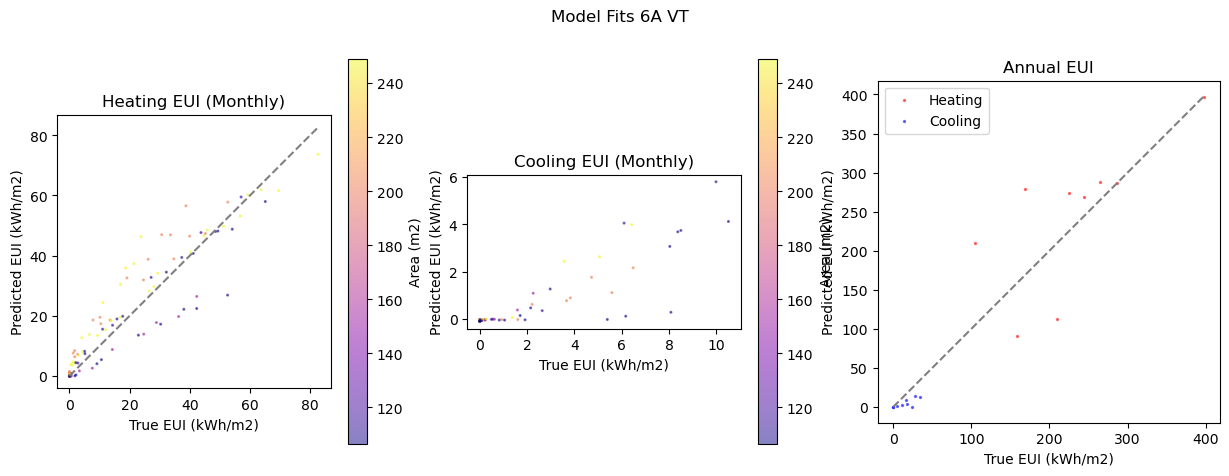

annual urban euis
               True        Pred
Name                           
Cooling   12.401720    3.925050
Heating  229.971469  257.824768
building errors
        Annual             Monthly           
        CVRMSE  NMBE  RMSE  CVRMSE  NMBE RMSE
Name                                         
Cooling   88.0 -69.6  13.4   128.2 -69.6  2.1
Heating   29.4   7.0  67.4    39.7   7.0  7.6


In [5]:
max_buildings = 10  # set to None to run all buildings in county
use_pred_caching = False
use_parquet_caching = True
apply_cops = True
res_schedule_path = Path("data/resstock/res_schedule.npy")
dummy_epw_filename = "dummy.epw"
county_id = "G0500070"
# run_counties = [county_id] # uncomment this line to only run a single county!

# model config
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

error_dfs = []
preds_dfs = []
ubem_dfs = []
for county_id in tqdm(run_counties):
    gc.collect()
    print("\n", "-" * 20, county_id, "-" * 20)
    # county_id = county_list[0]
    # county_id = counties_by_cz["6A"][0]

    surr_cache_key = f"{registry}/{model}/{tag}/{resource}"
    if surr_cache_key in surrogate_cache:
        print("Loading surrogate model from cache...")
        surrogate, trainer = surrogate_cache[surr_cache_key]
    else:
        print("Loading surrogate model from registry...")
        surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
        surrogate.model.eval()
        torch.set_float32_matmul_precision("medium")
        trainer = Trainer(
            accelerator="auto",
            devices="auto",
            strategy="auto",
            enable_progress_bar=True,
        )
        surrogate_cache[surr_cache_key] = (surrogate, trainer)
    print("Surrogate model loaded.")

    print("Loading Data For County")
    county_data = tract_df[[puma_col, weather_file_col]].loc[county_id]
    # assert county_data.nhgis_puma_gisjoin.nunique() < 5
    if isinstance(county_data[puma_col], pd.Series):
        if county_data[puma_col].nunique() > 5:
            print(
                f"County {county_id} has {county_data[puma_col].nunique()} PUMAs; lat/lon may be off"
            )
        puma_join = county_data[puma_col].values[0]
    else:
        puma_join = county_data[puma_col]

    row = gdf.set_index("GISJOIN").loc[puma_join]
    lon, lat = row.geometry.centroid.x, row.geometry.centroid.y
    print(row)
    county_features = rs_df.xs(county_id, level="county")
    print(f"done loading data for county: found {len(county_features)} buildings")

    assert (
        res_schedule_path.exists()
    ), f"Residential schedule file not found: {res_schedule_path.as_posix()}"
    occ_sched = np.load(res_schedule_path)[-1]
    if max_buildings is None:
        features = county_features.copy(deep=True)
    else:
        max_buildings_ = min(max_buildings, len(county_features))
        features = county_features.iloc[:max_buildings_]
    features = features.reset_index()
    # features = features[features.floors == 4]
    assert "building_id" in features.columns

    """
    ####################
    PULL BUILDING DATA
    ####################
    """
    results_files = features.results
    assert results_files.nunique() == len(features)

    with tempfile.TemporaryDirectory() as tempdir:
        cache_key = hash(f"{features.to_json()}")
        if use_parquet_caching and cache_key in parquet_cache:
            df_out = parquet_cache[cache_key]
        else:
            dl_parquet = partial(
                download_and_open_parquet,
                s3_client=s3_nrel,
                bucket=nrel_bucket,
            )
            print(f"Attempting to pull {len(results_files)} parquet files...")
            with ThreadPoolExecutor(max_workers=14) as executor:
                df_out = pd.concat(
                    list(
                        tqdm(
                            executor.map(dl_parquet, results_files),
                            total=len(results_files),
                        )
                    ),
                    keys=features.building_id,
                )
            if use_parquet_caching:
                parquet_cache[cache_key] = df_out
            print(
                f"Succesfully pulled {df_out.index.get_level_values('building_id').nunique()} parquet files."
            )

    """
    ####################
    EPD/LPD HANDLING
    ####################
    """
    print("Preparing EPD/LPD features...")
    elec_kWh = df_out[elec_cols].sum(axis=1).unstack(level="building_id")
    lighting_kWh = df_out[light_cols].sum(axis=1).unstack(level="building_id")
    footprint_area = features.area.values
    n_floors = features.floors.values
    area = footprint_area  # * n_floors
    elec_W = elec_kWh * 1000
    lighting_W = lighting_kWh * 1000
    peak_elec = elec_W.max()
    peak_lighting = lighting_W.max()
    peak_elec = peak_elec.replace(0, 1)  # prevent divide by zero errors
    peak_lighting = peak_lighting.replace(0, 1)
    elec_W = elec_W.T
    lighting_W = lighting_W.T
    epd = peak_elec / area
    lpd = peak_lighting / area
    elec_frac = elec_W / peak_elec.values.reshape(-1, 1)
    lighting_frac = lighting_W / peak_lighting.values.reshape(-1, 1)
    del elec_kWh, lighting_kWh, elec_W, lighting_W
    gc.collect()
    if len(elec_frac) == 0:
        continue
    schedules = np.stack(
        [
            elec_frac.values,
            lighting_frac.values,
            occ_sched.reshape(1, 8760).repeat(len(features), axis=0),
        ],
        axis=1,
    )
    # matches the schedule stacking, each a unique schedule
    features["template_idx"] = range(len(features))
    assert (features.building_id == epd.index).all()
    assert (features.building_id == lpd.index).all()

    print("Done preparing EPD/LPD features.")

    """
    ####################
    FEATURE SETTING
    ####################
    """
    print("Preparing shoebox features...")
    for i in range(12):
        features[f"shading_{i}"] = 0

    # Set shading to right and left (45 deg.) to ShadHeight
    try:
        for i in [0, 1, 2, 8, 10, 11]:
            features[f"shading_{i}"] = features["ShadHeight"]
    except:
        pass

    features["EquipmentPowerDensity"] = epd.values
    features["LightingPowerDensity"] = lpd.values
    features["LightingPowerDensity"] = lpd.values
    features["RecoverySettings"] = 0
    # features["SlabRValue"] = 0.35
    # features["RoofRValue"] = features["RoofRValue"] / 2
    # features["FacadeRValue"] = features["FacadeRValue"] / 2
    # features["perim_depth"] = 3
    # features["core_depth"] = 7
    # features["ground_2_footprint"] = 1.0
    # features["roof_2_footprint"] = 1.0
    # features["RoofRValue"] = features["RoofRValue"] / 3

    # setpoint handling
    setpoints = features[["HeatingSetpoint", "CoolingSetpoint"]].values
    new_sp = np.ones_like(setpoints) * setpoints
    sp_crossover_violation = setpoints[:, 0] > setpoints[:, 1]
    new_sp[sp_crossover_violation, 0] = setpoints[sp_crossover_violation, 1] - 0.01
    assert (new_sp[:, 0] <= new_sp[:, 1]).all()
    # features["HeatingSetpoint"] = new_sp[:, 0]
    # features["CoolingSetpoint"] = new_sp[:, 1]
    print(f"{sp_crossover_violation.sum()} setpoints are crossed over.")
    hsp_conf = surrogate.space_config["HeatingSetpoint"]
    csp_conf = surrogate.space_config["CoolingSetpoint"]
    hsp_oob = (features["HeatingSetpoint"] > hsp_conf["max"]) | (
        features["HeatingSetpoint"] < hsp_conf["min"]
    )
    csp_oob = (features["CoolingSetpoint"] > csp_conf["max"]) | (
        features["CoolingSetpoint"] < csp_conf["min"]
    )
    sp_oob = hsp_oob | csp_oob
    print(
        f"{sp_oob.sum()} setpoints are out of bounds (heating: {hsp_oob.sum()}, cooling:{csp_oob.sum()})."
    )
    sp_error_mask = sp_crossover_violation | sp_oob
    print(f"{sp_error_mask.sum()} buildings have setpoint errors.")
    features = features[~sp_error_mask]
    df_out = df_out[
        df_out.index.get_level_values("building_id").isin(features.building_id)
    ]

    print(f"{len(features)} buildings remain after setpoint errors.")

    #################### Infiltration Handling
    # original_infil_min = features.Infiltration.min()
    # original_infil_max = features.Infiltration.max()
    # infil_range = original_infil_max - original_infil_min
    # infil_range = np.where(np.abs(infil_range - 0) > 1e-6, infil_range, 1)
    # original_infil_scalar = (
    #     features.Infiltration.values.reshape(-1, 1) - original_infil_min
    # ) / (infil_range.reshape(-1, 1)) * 2 - 1
    # winter_infil = 0.000075
    # summer_infil = 0.001
    # winter_infil_var_percent = 0.5
    # summer_infil_var_percent = 0.2
    # # winter_infil = 0.0001
    # # summer_infil = 0.001
    # # winter_infil_var_percent = 0.0
    # # summer_infil_var_percent = 0.0
    # features["WinterInfiltration"] = (
    #     winter_infil + winter_infil * winter_infil_var_percent * original_infil_scalar
    # )
    # features["SummerInfiltration"] = (
    #     summer_infil + summer_infil * summer_infil_var_percent * original_infil_scalar
    # )

    # NEW INFILTRATION
    summer_infil = 0.0001
    summer_infil_var_percent = 0.2
    features["WinterInfiltration"] = features.Infiltration
    # features["SummerInfiltration"] = features.Infiltration
    features["SummerInfiltration"] = (
        summer_infil + summer_infil * summer_infil_var_percent * features.Infiltration
    )

    ##### Finalizing

    features["weight"] = 0.25
    features = features.set_index("building_id")
    bldg_ids = features.index.values

    ############## Shoebox Generation
    # 8 sb per building because 4 orientations and 2 seasons with different infiltration rates
    bldg_ids_for_sb = np.repeat(bldg_ids, 8)
    is_summer = np.tile(np.array([False, True]), len(bldg_ids)).repeat(4)
    sb_features = features.loc[bldg_ids_for_sb]
    sb_features["is_summer"] = is_summer
    sb_features["sb_orientation_ix"] = np.tile(np.tile(np.arange(4), len(bldg_ids)), 2)
    sb_features["orientation"] = (
        sb_features.sb_orientation_ix / 4 * 2 * np.pi + sb_features.orientation
    ) % (2 * np.pi)
    # sb_features.loc[~sb_features.is_summer, "Infiltration"] = winter_infil
    # sb_features.loc[sb_features.is_summer, "Infiltration"] = summer_infil
    sb_features.loc[~sb_features.is_summer, "Infiltration"] = sb_features.loc[
        ~sb_features.is_summer, "WinterInfiltration"
    ]
    sb_features.loc[sb_features.is_summer, "Infiltration"] = sb_features.loc[
        sb_features.is_summer, "SummerInfiltration"
    ]

    sb_features = sb_features.reset_index()
    sb_features.loc[sb_features.is_summer, "building_id"] = -sb_features.loc[
        sb_features.is_summer, "building_id"
    ]

    print("Done preparing shoebox features.")

    """
    ####################
    WEATHER
    ####################
    """
    print("Preparing weather...")
    if len(features) == 0:
        continue
    epw_files = features.epw.unique()
    assert len(epw_files) == 1
    epw_file = epw_files[0]
    print(
        f"Will process {len(features)}/{len(county_features)} buildings in {county_id} county."
    )
    # TODO: we can manually construct climate directly from climate_csv
    # if we can compute the lat/lon directly from the county code.
    #  once we have lat lon we can also compute solar positions identically to as in 'extract'
    # Instead, we have to open the original location based epw, and then overwrite with data from the downloaded csv
    weather_folder = root_folder / "weather"
    if not weather_folder.exists():
        weather_folder.mkdir(exist_ok=True, parents=True)
    dummy_epw_path = weather_folder / dummy_epw_filename
    assert (
        dummy_epw_path.exists()
    ), f"Dummy EPW file not found.  Please place {Path(dummy_epw_filename).name} in {weather_folder.as_posix()}."

    epw = EPW(dummy_epw_path)
    epw.location.latitude = lat
    epw.location.longitude = lon
    climate = extract(epw, surrogate.weather_transform.channel_names)
    epw_csv_data = download_and_open_epw_csv(
        s3_client=s3_nrel,
        bucket=nrel_bucket,
        local_output_path=weather_folder,
        key=epw_file,
    )
    for key, val in channel_map.items():
        if val is None:
            continue
        if isinstance(val, str):
            climate[surrogate.weather_transform.channel_names.index(key)] = (
                epw_csv_data[val].values
            )
        elif callable(val):
            climate[surrogate.weather_transform.channel_names.index(key)] = val(
                epw_csv_data
            )

    print("Done preparing weather")

    """
    ####################
    PREDICTIONS
    ####################
    """
    cache_key = hash(f"{(sb_features.to_json(), schedules, climate)}")
    if not use_pred_caching:
        print("Clearing prediction cache.")
        preds_cache = {}
    if cache_key in preds_cache and use_pred_caching:
        sb_preds, monthly_preds, annual_preds = preds_cache[cache_key]
    else:
        sb_preds, monthly_preds, annual_preds = predict_ubem(
            trainer=trainer,
            surrogate=surrogate,
            features=sb_features,
            schedules=schedules,
            climate=climate,
            apply_cops=apply_cops,
            batch_size=32,
        )
        del schedules
        gc.collect()
        monthly_preds["Cooling"] = monthly_preds.loc[
            -monthly_preds.index, "Cooling"
        ].values
        monthly_preds = monthly_preds.loc[monthly_preds.index > 0]
        annual_preds["Cooling"] = annual_preds.loc[
            -annual_preds.index, "Cooling"
        ].values
        annual_preds = annual_preds.loc[annual_preds.index > 0]
        no_thermal = df_out[res_thermal_output_cols].groupby("building_id").sum() < 0.1
        no_heating = no_thermal["out.load.heating.energy_delivered.kbtu"]
        no_cooling = no_thermal["out.load.cooling.energy_delivered.kbtu"]
        monthly_preds.loc[:, ("Heating", slice(None))] = monthly_preds.loc[
            :, ("Heating", slice(None))
        ] * (~no_heating).values.reshape(-1, 1)
        monthly_preds.loc[:, ("Cooling", slice(None))] = monthly_preds.loc[
            :, ("Cooling", slice(None))
        ] * (~no_cooling).values.reshape(-1, 1)
        annual_preds.loc[:, "Heating"] = annual_preds["Heating"] * (~no_heating)
        annual_preds.loc[:, "Cooling"] = annual_preds["Cooling"] * (~no_cooling)

        preds_cache[cache_key] = (
            sb_preds,
            monthly_preds,
            annual_preds,
        )

    """
    ####################
    EVALUATION
    ####################
    """
    print("Beginning evaluation...")
    area = features.area.values.reshape(-1, 1)
    kWh_per_kBtu = 1 / 3.412
    y_true = df_out[
        [
            "out.load.heating.energy_delivered.kbtu",
            "out.load.cooling.energy_delivered.kbtu",
        ]
    ]
    del df_out
    gc.collect()
    y_true.columns = ["Heating", "Cooling"]
    monthly_preds = monthly_preds[y_true.columns]

    y_true = y_true.unstack(level="building_id")
    y_true = y_true.resample("1M").sum()
    y_true = (
        y_true.stack(level="building_id").unstack(level="timestamp")
        * kWh_per_kBtu
        / area
    )
    y_true.columns = monthly_preds.columns
    if apply_cops:
        y_true["Cooling"] = y_true["Cooling"] / features.cop_cooling.values.reshape(
            -1, 1
        )
        y_true["Heating"] = y_true["Heating"] / features.cop_heating.values.reshape(
            -1, 1
        )

    annual_eui_true = y_true.T.groupby("Name").sum().T
    annual_gross_true = annual_eui_true * area
    annual_gross_preds = annual_preds * area
    annual_urban_gross_true = annual_gross_true.sum()
    annual_urban_gross_preds = annual_gross_preds.sum()
    annual_urban_eui_true = annual_urban_gross_true / area.sum()
    annual_urban_eui_preds = annual_urban_gross_preds / area.sum()
    annual_urban_eui = pd.concat(
        [annual_urban_eui_true, annual_urban_eui_preds], axis=1, keys=["True", "Pred"]
    )

    rmse_annual = (annual_eui_true - annual_preds).pow(2).mean().pow(0.5)
    cvrmse_annual = rmse_annual / annual_eui_true.mean()
    nmbe_annual = (annual_preds - annual_eui_true).mean() / annual_eui_true.mean()
    rmse_monthly = (
        (monthly_preds - y_true).pow(2).mean().groupby("Name").mean().pow(0.5)
    )
    cvrmse_monthly = rmse_monthly / y_true.mean().groupby("Name").mean()
    nmbe_monthly = (monthly_preds - y_true).mean().groupby(
        "Name"
    ).mean() / y_true.mean().groupby("Name").mean()
    rmse = pd.concat(
        [rmse_annual, rmse_monthly], axis=1, keys=["Annual", "Monthly"]
    ).round(1)
    cvrmse = (
        pd.concat([cvrmse_annual, cvrmse_monthly], axis=1, keys=["Annual", "Monthly"])
        * 100
    ).round(1)
    nmbe = (
        pd.concat([nmbe_annual, nmbe_monthly], axis=1, keys=["Annual", "Monthly"]) * 100
    ).round(1)
    errors = (
        pd.concat([rmse, cvrmse, nmbe], axis=1, keys=["RMSE", "CVRMSE", "NMBE"])
        .swaplevel(axis=1)
        .sort_index(axis=1)
    )
    errors
    print("Done evaluating.")
    """
    ####################
    PLOTTING
    ####################
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"Model Fits {features.iloc[0].climate_zone} {features.iloc[0].state}")
    for i, target in enumerate(["Heating", "Cooling"]):
        y_true_col = y_true[target].values.flatten()
        y_pred_col = monthly_preds[target].values.flatten()
        sc = ax[i].scatter(
            y_true_col,
            y_pred_col,
            s=1.5,
            alpha=0.5,
            # color="blue" if target == "Cooling" else "red",
            c=county_features.loc[monthly_preds.index].area.values.repeat(12),
            cmap="plasma",
            label=target,
        )
        ax[i].plot(
            [0, y_true_col.max()],
            [0, y_true_col.max()],
            color="gray",
            linestyle="--",
        )
        fig.colorbar(sc, ax=ax[i], label="Area (m2)")
        ax[i].set_xlabel("True EUI (kWh/m2)")
        ax[i].set_ylabel("Predicted EUI (kWh/m2)")
        ax[i].set_title(f"{target} EUI (Monthly)")
        ax[i].set_aspect("equal", adjustable="box")

        ax[2].scatter(
            annual_eui_true[target],
            annual_preds[target],
            color="blue" if target == "Cooling" else "red",
            label=target,
            s=2,
            alpha=0.5,
        )
    ax[2].set_title("Annual EUI")
    ax[2].set_xlabel("True EUI (kWh/m2)")
    ax[2].set_ylabel("Predicted EUI (kWh/m2)")
    ax[2].plot(
        [0, annual_eui_true.max().max()],
        [0, annual_eui_true.max().max()],
        color="gray",
        linestyle="--",
    )
    ax[2].set_aspect("equal", adjustable="box")
    ax[2].legend()

    fig.tight_layout()
    plt.show()

    print("annual urban euis")
    print(annual_urban_eui)
    print("building errors")
    print(errors)

    """
    ####################
    SAVE RESULTS
    ####################
    """
    X = features.reset_index()
    df = pd.concat(
        [monthly_preds, y_true], axis=1, keys=["Predicted", "True"], names=["Segment"]
    )
    assert (df.index.values == X.building_id.values).all()
    df.index = pd.MultiIndex.from_frame(X)
    fp = county_fp_output_formatter(county_id)
    df.to_hdf(fp, mode="w", key="preds_and_true")
    errors.to_hdf(fp, mode="a", key="errors")
    annual_urban_eui.to_hdf(fp, mode="a", key="urban_eui")
    preds_dfs.append(df)
    error_dfs.append(errors)
    ubem_dfs.append(annual_urban_eui)

    gc.collect()
all_errors = pd.concat(error_dfs, axis=0, keys=run_counties, names=["county"])
all_urbans = pd.concat(ubem_dfs, axis=0, keys=run_counties, names=["county"])
all_preds = pd.concat(preds_dfs, axis=0, keys=run_counties, names=["county"])
all_preds.columns.names = ["segment", "end_use", "month"]
all_preds.to_hdf(aggregated_results_path, mode="w", key="preds_and_true")
all_errors.to_hdf(aggregated_results_path, mode="a", key="errors")
all_urbans.to_hdf(aggregated_results_path, mode="a", key="urban_eui")

### Results

In [9]:
# reload from disk with "from_folder"
load_config = {
    "folder": outputs_folder / "counties",
    "from_disk": False,
    "version_to_load": version,
    "upgrade_to_load": upgrade_state,
}


if load_config["from_disk"]:
    raise NotImplementedError("This code needs to be refactored")
    matcher = f"resstock*{'_G' if load_config['from_counties'] else ''}*_{load_config['version_to_load']}.hdf"
    preds_dfs = []
    ubem_dfs = []
    error_dfs = []
    for file in Path(load_config["folder"]).glob(matcher):
        error_dfs.append(pd.read_hdf(file, key="errors"))
        ubem_dfs.append(pd.read_hdf(file, key="urban_eui"))
        preds_dfs.append(pd.read_hdf(file, key="preds_and_true"))
    run_counties = [
        file.stem.split("_")[2] for file in Path(load_config["folder"]).glob(matcher)
    ]
    all_errors = pd.concat(error_dfs, axis=0, keys=run_counties, names=["county"])
    all_urbans = pd.concat(ubem_dfs, axis=0, keys=run_counties, names=["county"])
    all_preds = pd.concat(preds_dfs, axis=0, keys=run_counties, names=["county"])
    all_preds.columns.names = ["segment", "end_use", "month"]
    print(f"Loaded {len(all_preds)} buildings from disk.")

all_areas = all_preds.index.get_level_values("area")
total_monthly_energy = all_preds * all_areas.values.reshape(-1, 1)

In [10]:
# TODO: predict total energy usage for the counties by buildings; see how well we predict each county.
data = all_preds
# data = total_monthly_energy
res = (all_preds["Predicted"] - all_preds["True"]).T.groupby("end_use").sum().T
squared_error = res.pow(2)
mse_by_cz_and_end_use = squared_error.groupby("climate_zone").mean().sort_index()
true_mean_by_cz_and_end_use = (
    all_preds["True"]
    .T.groupby("end_use")
    .sum()
    .T.groupby("climate_zone")
    .mean()
    .sort_index()
)
cvrmse_by_cz_and_end_use = (
    mse_by_cz_and_end_use.pow(0.5) / true_mean_by_cz_and_end_use
).sort_index() * 100
cvrmse_by_cz_and_end_use
nmbe_by_end_cz_and_end_use = (
    res.groupby("climate_zone").mean().sort_index() / true_mean_by_cz_and_end_use * 100
)
(nmbe_by_end_cz_and_end_use).round(1)

end_use,Cooling,Heating
climate_zone,,
6A,-69.6,7.0


In [11]:
national_energy_use = total_monthly_energy.sum().groupby(["segment", "end_use"]).sum()
national_energy_percent_error = (
    (national_energy_use["Predicted"] - national_energy_use["True"])
    / national_energy_use["True"]
).sort_index()
national_energy_percent_error * 100

end_use
Cooling   -68.350759
Heating    12.111633
dtype: float64

In [ ]:
county = "G1300450"
annual = stacked[stacked.index.isin([county], level=0)].sum(axis=0, level=1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

scale_y = 2
psize = 3
a = 1

ax[0].scatter(
    annual["True"].Heating,
    annual["Predicted"].Heating,
    s=psize,
    alpha=a,
    color="#4f77f4",
)
ax[0].set_aspect("equal", adjustable="box")
max_y = max(stacked["True"].Heating.max() * scale_y, 80)
ax[0].plot(
    [0, max_y],
    [0, max_y],
    linestyle="--",
    color="gray",
)
ax[0].set_ylim(0, max_y)
ax[0].set_xlim(0, max_y)
ax[0].set_title("Annual Heating EUI")
ax[0].set_xlabel("True EUI (kWh/m2)")
ax[0].set_ylabel("Predicted EUI (kWh/m2)")

ax[1].scatter(
    annual["True"].Cooling,
    annual["Predicted"].Cooling,
    s=psize,
    alpha=a,
    color="#ff6f6e",
)
ax[1].set_aspect("equal", adjustable="box")
scale_y = 0.5
max_y = max(stacked["True"].Cooling.max() * scale_y, 80)
ax[1].plot(
    [0, max_y],
    [0, max_y],
    linestyle="--",
    color="gray",
)
ax[1].set_ylim(0, max_y)
ax[1].set_xlim(0, max_y)
ax[1].set_title("Annual Cooling EUI")
ax[1].set_xlabel("True EUI (kWh/m2)")
ax[1].set_ylabel("Predicted EUI (kWh/m2)")

In [ ]:
stacked = all_preds.stack(level=["month"])
c = pd.Series(stacked.index.get_level_values("climate_zone")).apply(
    lambda x: czs.index(x)
)
scale_y = 0.5
psize = 0.05
a = 0.05

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    stacked["True"].Heating,
    stacked["Predicted"].Heating,
    s=psize,
    alpha=a,
    color="#4f77f4",
)
ax[0].set_aspect("equal", adjustable="box")
max_y = max(stacked["True"].Heating.max() * scale_y, 80)
ax[0].plot(
    [0, max_y],
    [0, max_y],
    linestyle="--",
    color="gray",
)
ax[0].set_ylim(0, max_y)
ax[0].set_xlim(0, max_y)
ax[0].set_title("Heating EUI")
ax[0].set_xlabel("True EUI (kWh/m2)")
ax[0].set_ylabel("Predicted EUI (kWh/m2)")

ax[1].scatter(
    stacked["True"].Cooling,
    stacked["Predicted"].Cooling,
    s=psize,
    alpha=a,
    color="#ff6f6e",
)
ax[1].set_aspect("equal", adjustable="box")
scale_y = 0.5
max_y = max(stacked["True"].Cooling.max() * scale_y, 80)
ax[1].plot(
    [0, max_y],
    [0, max_y],
    linestyle="--",
    color="gray",
)
ax[1].set_ylim(0, max_y)
ax[1].set_xlim(0, max_y)
ax[1].set_title("Cooling EUI")
ax[1].set_xlabel("True EUI (kWh/m2)")
ax[1].set_ylabel("Predicted EUI (kWh/m2)")

In [ ]:
rs_df.loc[
    rs_df.index.get_level_values("county").isin(
        all_preds.index.get_level_values("county")
    )
].index.get_level_values("county").value_counts().sort_index()
all_preds.index.get_level_values("county").value_counts().sort_index()

In [ ]:
total_monthly_res = total_monthly_energy["Predicted"] - total_monthly_energy["True"]
national_monthly_nmbe = (
    total_monthly_res.mean().groupby("end_use").mean()
    / total_monthly_energy["True"].mean().groupby("end_use").mean()
    * 100
)

total_county_area = all_preds.index.to_frame()[["area"]].groupby("county").sum()
total_county_energy = (
    total_monthly_energy.groupby("county").sum().T.groupby(["segment"]).sum().T
)
assert (total_county_energy.index == total_county_area.index).all()
total_county_eui = total_county_energy / total_county_area.values.reshape(-1, 1)
county_level_mape = (
    (total_county_energy["Predicted"] - total_county_energy["True"]).abs()
    / total_county_energy["True"]
).mean() * 100
county_level_eui_mape = (
    (total_county_eui["Predicted"] - total_county_eui["True"]).abs()
    / total_county_eui["True"]
).mean() * 100  # always identical to county_level_mape
total_county_energy_by_end_use = (
    total_monthly_energy.groupby("county")
    .sum()
    .T.groupby(["segment", "end_use"])
    .sum()
    .T
)
total_county_eui_by_end_use = (
    total_county_energy_by_end_use / total_county_area.values.reshape(-1, 1)
)
total_county_residual_by_end_use = (
    total_county_energy_by_end_use["Predicted"] - total_county_energy_by_end_use["True"]
)
total_county_eui_residual_by_end_use = (
    total_county_eui_by_end_use["Predicted"] - total_county_eui_by_end_use["True"]
)
total_county_rmse_by_end_use = total_county_residual_by_end_use.pow(2).mean().pow(0.5)
total_county_eui_rmse_by_end_use = (
    total_county_eui_residual_by_end_use.pow(2).mean().pow(0.5)
)
total_county_cvrmse_by_end_use = (
    total_county_rmse_by_end_use / total_county_energy_by_end_use["True"].mean() * 100
)
total_county_eui_cvrmse_by_end_use = (
    total_county_eui_rmse_by_end_use / total_county_eui_by_end_use["True"].mean() * 100
)
total_county_eui_mape_by_end_use = (
    total_county_eui_residual_by_end_use.abs() / total_county_eui_by_end_use["True"]
).mean() * 100
total_county_eui_cvrmse_by_end_use
county_level_mape, county_level_eui_mape
total_county_eui_mape_by_end_use

In [ ]:
total_monthly_res = total_monthly_energy["Predicted"] - total_monthly_energy["True"]
total_state_area = all_preds.index.to_frame()[["area"]].groupby("state").sum()
total_state_energy = (
    total_monthly_energy.groupby("state").sum().T.groupby(["segment"]).sum().T
)
assert (total_state_energy.index == total_state_area.index).all()
total_state_eui = total_state_energy / total_state_area.values.reshape(-1, 1)
state_level_mape = (
    (total_state_energy["Predicted"] - total_state_energy["True"]).abs()
    / total_state_energy["True"]
).mean() * 100
state_level_eui_mape = (
    (total_state_eui["Predicted"] - total_state_eui["True"]).abs()
    / total_state_eui["True"]
).mean() * 100  # always identical to state_level_mape
total_state_energy_by_end_use = (
    total_monthly_energy.groupby("state")
    .sum()
    .T.groupby(["segment", "end_use"])
    .sum()
    .T
)
total_state_eui_by_end_use = (
    total_state_energy_by_end_use / total_state_area.values.reshape(-1, 1)
)
total_state_residual_by_end_use = (
    total_state_energy_by_end_use["Predicted"] - total_state_energy_by_end_use["True"]
)
total_state_eui_residual_by_end_use = (
    total_state_eui_by_end_use["Predicted"] - total_state_eui_by_end_use["True"]
)
total_state_rmse_by_end_use = total_state_residual_by_end_use.pow(2).mean().pow(0.5)
total_state_eui_rmse_by_end_use = (
    total_state_eui_residual_by_end_use.pow(2).mean().pow(0.5)
)
total_state_cvrmse_by_end_use = (
    total_state_rmse_by_end_use / total_state_energy_by_end_use["True"].mean() * 100
)
total_state_eui_cvrmse_by_end_use = (
    total_state_eui_rmse_by_end_use / total_state_eui_by_end_use["True"].mean() * 100
)
total_state_eui_mape_by_end_use = (
    total_state_eui_residual_by_end_use.abs() / total_state_eui_by_end_use["True"]
).mean() * 100
total_state_eui_cvrmse_by_end_use
state_level_mape, state_level_eui_mape, total_state_eui_mape_by_end_use
total_state_eui_cvrmse_by_end_use

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
s = 24
a = 0.5
ax.scatter(
    total_state_eui_by_end_use["True"].Heating,
    total_state_eui_by_end_use["Predicted"].Heating,
    s=s,
    alpha=a,
    color="#ff6f6e",
    label="Heating",
)
ax.scatter(
    total_state_eui_by_end_use["True"].Cooling,
    total_state_eui_by_end_use["Predicted"].Cooling,
    s=s,
    alpha=a,
    color="#4f77f4",
    label="Cooling",
)
ax.plot(
    [0, total_state_eui_by_end_use["True"].max().max()],
    [0, total_state_eui_by_end_use["True"].max().max()],
    linestyle="--",
    color="gray",
    lw=0.75,
)
ax.set_aspect("equal", adjustable="box")
ax.set_title("State Level EUI")
ax.set_xlabel("True EUI (kWh/m2)")
ax.set_ylabel("Predicted EUI (kWh/m2)")
ax.legend()